In [1]:
import xarray as xr
from datetime import datetime
import glob
import cf_units
from scipy import stats
import numpy as np
import sys
from tqdm import tqdm_notebook as tqdm
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
import gc
import pandas as pd

In [2]:
## read in observations
def linregress_grid(df,df_time,start,end):
    x,y=np.meshgrid(np.arange(36),np.arange(72))
    slope=np.full([36,72],np.nan)
    i_start=np.where(df_time==start)[0][0]
    i_end=np.where(df_time==end)[0][0]
    
    for i_x, i_y in zip(x.flatten(),y.flatten()):
        if not np.all(np.isnan(df[i_start:i_end+1,i_x,i_y])):
            #print(np.all(df[i_start:i_end+1,i_x,i_y]==np.nan),df[i_start:i_end+1,i_x,i_y])
            slope[i_x,i_y]=100*stats.linregress(np.arange(end-start+1)[~np.isnan(df[i_start:i_end+1,i_x,i_y])],
                                                df[i_start:i_end+1,i_x,i_y][~np.isnan(df[i_start:i_end+1,i_x,i_y])])[0]
    return slope

hadcrut_med=xr.open_mfdataset('data/HadCRUT.4.6.0.0.median.nc')
hadcrut_med=hadcrut_med.groupby('time.year').mean('time')#.sel(time=slice('1870-01-01', '2101-01-01'))

trend_hadcrut_med={}

# trends for all years in temperature
for year in range(2000,2019):
 
    trend_hadcrut_med[year]=linregress_grid(hadcrut_med.sel(year=slice(1870,2021)).roll(longitude=180, roll_coords=True).temperature_anomaly.values,
                         hadcrut_med.sel(year=slice(1870,2021)).year.values,1951,year)

In [3]:
models=[
    'MIROC6', 
    'IPSL-CM6A-LR', 
    'CanESM5', 
    'HadGEM3-GC31-LL', 
    'CNRM-CM6-1', 
    'GFDL-ESM4', 
    'ACCESS-ESM1-5', 
    'BCC-CSM2-MR', 
    'NorESM2-LM', 
    'MRI-ESM2-0'
]
    
dir_var = '/home/sarah/projects/CVM3/data/models/tas/'
member = 'r*1p1f1'
obs = 'tas' # temperature above soil
time_res = 'ann'
period = 2018-1870

hist_name = 'historical'
ssp_name  ='ssp*' 
hn_name   = 'hist-nat'
pi_name   = 'piControl'

def get_run_nr(filename):
    run = filename.split('_')[-2]
    return run.split("i1p1f1")[0][1:]

y_af = {}
y_hn = {}
y_pi = {}

time_af={}
time_hn={}
time_pi={}


### get usable models
usable_models = []
for model in models:
    y_af[model] = {}
    y_hn[model] = {}
    y_pi[model] = {}
    
    time_af[model]=[]
    time_hn[model]=[]
    time_pi[model]=[]

    
    # example file: tas_ann_MIROC6_historical_r3i1p1f1_g5.nc
    hist_name_list=sorted(glob.glob(f'{dir_var}{model}/g5/{obs}_{time_res}_{model}_{hist_name}_{member}_g5.nc'))
    ssp_name_list=sorted(glob.glob(f'{dir_var}{model}/g5/{obs}_{time_res}_{model}_{ssp_name}_{member}_g5.nc'))
    hn_name_list=sorted(glob.glob(f'{dir_var}{model}/g5/{obs}_{time_res}_{model}_{hn_name}_{member}_g5.nc'))
    pi_name_list=sorted(glob.glob(f'{dir_var}{model}/g5/{obs}_{time_res}_{model}_{pi_name}_{member}_g5.nc'))
    
    for i, hist in enumerate(hist_name_list):
        run = get_run_nr(hist)
        # all forcing: combination of historical and projection of shared socioeconomic pathways
        i_ssp = i % (len(ssp_name_list))
        try: 
            data = xr.open_mfdataset([hist, ssp_name_list[i_ssp]],combine='nested', concat_dim='time').sel(time=slice('1870-01-01', '2019-01-01'))
            y_af[model][run] = data.tas.values
            time_af[model].append(data.time)
        except:
            pass

    for hn in hn_name_list:
        run = get_run_nr(hn)
        data = xr.open_dataset(hn).sel(time=slice('1870-01-01', '2019-01-01'))
        y_hn[model][run] = data.tas.values
        time_hn[model].append(data.time)
        
    for pi in pi_name_list:
        run = get_run_nr(pi)
        data = xr.open_dataset(pi)
        y_pi[model][run] = data.tas.values
        time_pi[model].append(data.time)

    len_af=len(y_af[model])
    len_hn=len(y_hn[model])
    len_pi=len(y_pi[model])
    
    #models only usable if all-forcing run exists, at least 3 histNat runs exist and length of histNat is same as period under investigation
    diff_period_hn_time = [len(time) - period for time in time_hn[model] ]
    if len_af<1 or len_hn<3 or any(d < 0 for d in diff_period_hn_time):
        print('\nCannot use model data for', model)
        print(f'AF run number: {len_af}, time length of: {[len(time) for time in time_af[model] ]}')
        print(f'HN run number: {len_hn}, time length of: {[len(time) for time in time_hn[model] ]}')
        
    else:        
        print('\nGot model data for', model)
        usable_models.append(model)
        print(f'AF run number: {len(y_af[model])}, time length of: {[len(time) for time in time_af[model] ]}')
        print(f'HN run number: {len(y_hn[model])}, time length of: {[len(time) for time in time_hn[model] ]}')
        print(f'PI run number: {len(y_pi[model])}, time length of: {[len(time) for time in time_pi[model] ]}')

models = usable_models



Got model data for MIROC6
AF run number: 50, time length of: [149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149]
HN run number: 50, time length of: [149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149]
PI run number: 1, time length of: [800]

Got model data for IPSL-CM6A-LR
AF run number: 33, time length of: [149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149]
HN run number: 10, time length of: [149, 149, 149, 149, 149, 149, 149, 149, 149, 149]
PI run number: 1, time length of: [2000]


In [4]:
from scipy.stats import linregress

## Drift correct the models preindustrial control runs
y_pi_dc={}

for model in models:
    first_key = list(y_pi[model].keys())[0]
    if len(y_pi[model])>1:
        y_pi_temp=np.vstack(([y_pi[model][key] for key in y_pi[model].keys()]))
        y_pi_dc[model]=np.zeros_like(y_pi_temp)
    else:
        y_pi_dc[model]=np.zeros_like(y_pi[model][first_key])
        
    x,y=np.meshgrid(np.arange(y_pi[model][first_key].shape[1]),np.arange(y_pi[model][first_key].shape[2]))
    
    i_key=0
    for key in y_pi[model].keys():
        for i_x, i_y in zip(x.flatten(),y.flatten()):
            #print(i_x,i_y)
            slope, intercept,_,_,_=linregress(np.arange(y_pi[model][key].shape[0]),
                                              y_pi[model][key][:,i_x,i_y])
            drift=slope*np.arange(y_pi[model][key].shape[0])+intercept
            y_pi_dc[model][i_key:i_key+y_pi[model][key].shape[0],i_x,i_y]=y_pi[model][key][:,i_x,i_y]-drift
            
        i_key+=y_pi[model][key].shape[0]
        

In [5]:
##function to calculate 7 year moving average

def butter(df):
    
    output=np.zeros_like(df)
    for i_x,i_y in zip(x.flatten(),y.flatten()):
        output[:,i_x,i_y] = np.convolve(df[:,i_x,i_y].flatten(),np.ones(7)/7, mode='full')[:-6]
    
    output=output[6:,:,:]
    output=output[:-6,:,:]
    
    return output


In [9]:
def create_mask(df):
    
    ##First check that the year is 'valid' i.e. 6 months are non nana
    df=df.reshape(-1,12,df.shape[1],df.shape[2])
    valid_idx=np.zeros([df.shape[0],36,72])
    
    for yr_idx in range(df.shape[0]):
        valid_idx[yr_idx,:,:]=np.where(np.isnan(df[yr_idx,:,:,:]).sum(axis=0)>7,1,0)
        
    cutoff=valid_idx.shape[0]%5   
    valid_idx=valid_idx[cutoff:,:,:].reshape(5,-1,36,72)    
    mask_idx=np.zeros([5,36,72])
    
    for idx_block in range(5):
        mask_idx[idx_block,:,:]=np.where(valid_idx[idx_block,:,:,:].sum(axis=0)>np.floor(0.8*valid_idx.shape[1]),
                                               np.nan,1)
    print(valid_idx.shape,np.floor(0.8*valid_idx.shape[1]))
    mask_idx=np.prod(mask_idx,axis=0)
    
    return np.roll(~np.isnan(mask_idx),36,1)

## Calculate Internal Variability for smoothed observations
y_af_all=np.stack(([y_af[model][key] for model in  y_pi_dc.keys() for key in y_af[model]]))

## create mask based on criteria 
hadcrut = xr.open_mfdataset('data/HadCRUT.4.6.0.0.median.nc')
mask_1951 = create_mask(hadcrut.sel(time=slice('1951-01-01', '2019-01-01')).temperature_anomaly.values)

##detrend observations assuming models have accurate trend
hadcrut_med_detrend=hadcrut.sel(time=slice('1870','2018')).groupby('time.year').mean('time').roll(longitude=180, roll_coords=True).temperature_anomaly.values-np.mean(y_af_all,axis=0)
hadcrut_med_detrend=butter(hadcrut_med_detrend)

hadcrut_var=np.nanstd(hadcrut_med_detrend,axis=0)
nan_mask=~mask_1951 ##mask out values where observations are considered incomplete 
hadcrut_var[nan_mask]=np.nan 


(5, 13, 36, 72) 10.0


(0.0, 1.0, 0.0, 1.0)

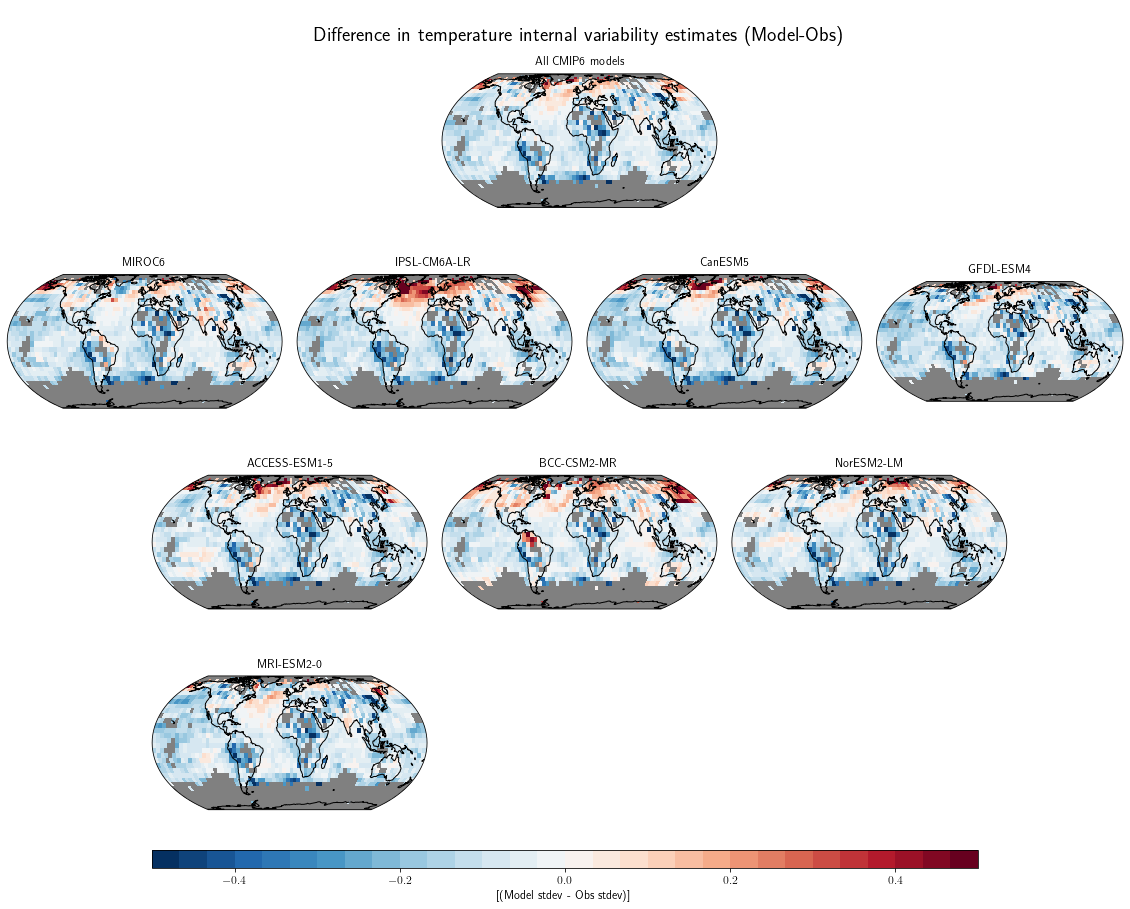

In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

#plot difference in internal variability of smoothed model runs and smoothed observations

n_col = 4
n_row = 4

lons=hadcrut.longitude.values
lats=hadcrut.latitude.values

fig=plt.figure(figsize=(n_col*5, n_row * 4))
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'mathtext.default':'regular'}) 
plt.rcParams.update({'mathtext.default':'it'}) 

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
})
grid = plt.GridSpec(n_row*3+1, n_col*9+3, wspace=1, hspace=0) # create a grid for the subplots #0.12

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

i=0
i_y=0

for i in range(len(models)+1):
    
    if i==0:
        mod_pi_var=np.mean(np.stack(([np.nanstd(butter(y_pi[model][key]),axis=0) for model in y_pi.keys() for key in y_pi[model].keys()])),axis=0)
        nan_mask=~mask_1951
        mod_pi_var[nan_mask]=np.nan 

        ax = plt.subplot(grid[i+1:i+3,(i_y+1)*10+5:(i_y+1)*10+15], projection=ccrs.EqualEarth())
        
    elif i<5:
        mod_pi_var=np.mean(np.stack(([np.nanstd(butter(y_pi[models[i-1]][key]),axis=0) for key in y_pi[models[i-1]].keys()])),axis=0)
        nan_mask=~mask_1951
        mod_pi_var[nan_mask]=np.nan 
        
        ax = plt.subplot(grid[4:6,i_y*10:i_y*10+10], projection=ccrs.EqualEarth(central_longitude=0))
        i_y+=1
    
    elif i>4:
        mod_pi_var=np.mean(np.stack(([np.nanstd(butter(y_pi[models[i-1]][key]),axis=0) for key in y_pi[models[i-1]].keys()])),axis=0)
        nan_mask=~mask_1951
        mod_pi_var[nan_mask]=np.nan 
        if (i-5)%3==0:
            i_y=0
            ax = plt.subplot(grid[i+2:i+4,i_y*10+5:i_y*10+15], projection=ccrs.EqualEarth(central_longitude=0))

        else:
            ax = plt.subplot(grid[(i-5)-((i-5)%3)+7:(i-5)-((i-5)%3)+9,i_y*10+5:i_y*10+15], projection=ccrs.EqualEarth(central_longitude=0))
        i_y+=1
        
    ax.coastlines()
    mesh_1=ax.pcolormesh(lons, lats, (mod_pi_var-np.roll(hadcrut_var,36,axis=1)), transform=ccrs.PlateCarree(), cmap=plt.cm.get_cmap('RdBu_r',30), vmin=-0.5, vmax=0.5, rasterized=True)
    if i==0:
        ax.set_title("All CMIP6 models",y=1.02,fontsize=12)
    else:
        ax.set_title(models[i-1],y=1.02,fontsize=12)
    cmap_mesh=mesh_1.get_cmap()
    cmap_mesh.set_bad('gray')
    mesh_1.set_cmap(cmap_mesh)

axtitle = plt.subplot(grid[0,6:-5])
plt.title('Difference in temperature internal variability estimates (Model-Obs)',fontsize=20, y=0.4)      
plt.axis('off') 

axcbar = plt.subplot(grid[-1:,5:-5])
cbar=plt.colorbar(mesh_1,orientation='horizontal',fraction=0.4,aspect=45)
cbar.set_label('[(Model stdev - Obs stdev)]')  
plt.axis('off') 


In [11]:
#create trend distributions for all-forcing and natural-forcing runs by resampling variability 
#from piControl runs

def mean_trend_from_dict(df,df_time,start,end, roll=False):
    all_trends=np.stack([linregress_grid(df[key],df_time,start,end) for key in tqdm(df.keys())])
    
    if roll:
        return np.roll(np.mean(all_trends,axis=0),36,1)
    else:
        return np.mean(all_trends,axis=0)

def linregress_grid(df,df_time,start,end):
    x,y=np.meshgrid(np.arange(36),np.arange(72))
    slope=np.full([36,72],np.nan)
    i_start=np.where(df_time==start)[0][0]
    i_end=np.where(df_time==end)[0][0]
    
    for i_x, i_y in zip(x.flatten(),y.flatten()):
        if not np.all(np.isnan(df[i_start:i_end+1,i_x,i_y])):
            #print(np.all(df[i_start:i_end+1,i_x,i_y]==np.nan),df[i_start:i_end+1,i_x,i_y])
            slope[i_x,i_y]=100*stats.linregress(np.arange(end-start+1)[~np.isnan(df[i_start:i_end+1,i_x,i_y])],
                                                df[i_start:i_end+1,i_x,i_y][~np.isnan(df[i_start:i_end+1,i_x,i_y])])[0]
    return slope

n_samples=50

y_af_all=np.stack(([y_af[model][key] for model in  y_pi_dc.keys() for key in y_af[model]]))
hadcrut=xr.open_mfdataset('data/HadCRUT.4.6.0.0.median.nc')
hadcrut_med_detrend=hadcrut.sel(time=slice('1870','2018')).groupby('time.year').mean('time').roll(longitude=180, roll_coords=True).temperature_anomaly.values-np.mean(y_af_all,axis=0)
obs_std=np.nanstd(butter(hadcrut_med_detrend),axis=0)

trend_hn = {}
trend_af = {}
resampled_trend_hn = {}
resampled_trend_af = {}
time = {}
ref_year = 1951

for model in models:
    time[model]=np.arange(1870,2019)
    trend_hn[model]={}
    trend_af[model]={}
    resampled_trend_hn[model] = {}
    resampled_trend_af[model] = {}

    mod_std=np.mean(np.stack(([np.nanstd(butter(y_pi[model][key]),axis=0) for key in y_pi[model].keys()])),axis=0)
    std_corr=obs_std/mod_std
    
    print('Creating trend distribution for', model)
    
    for year in range(2000,2019):
        print(year)
        trend_hn[model][year] = mean_trend_from_dict(y_hn[model],time[model],ref_year,year,roll=True)
        trend_af[model][year] = mean_trend_from_dict(y_af[model],time[model],ref_year,year,roll=True)
  
        #start resampling procedure for creation of distribution
        resampled_trend_hn[model][year]=np.zeros([n_samples, trend_hn[model][year].shape[0], trend_hn[model][year].shape[1]])
        resampled_trend_af[model][year]=np.zeros([n_samples, trend_af[model][year].shape[0], trend_af[model][year].shape[1]])
  

        for sample in tqdm(range(n_samples)):

            start_pi=np.random.randint(0,y_pi_dc[model].shape[0]-(year-ref_year))
            end_pi=start_pi+(year-ref_year)

            resampled_trend_hn[model][year][sample,:,:] = (
                (linregress_grid(y_pi_dc[model],np.arange(y_pi_dc[model].shape[0]),start_pi,end_pi)*std_corr)
                + trend_hn[model][year])
            resampled_trend_af[model][year][sample,:,:] = (
                (linregress_grid(y_pi_dc[model],np.arange(y_pi_dc[model].shape[0]),start_pi,end_pi)*std_corr)
                + trend_af[model][year])

Creating trend distribution for MIROC6
2000


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

2001


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

2002


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

2003


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

2004


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

2005


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

2006


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

2007


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

2008


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

2009


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

2010


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

2011


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

2012


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

2013


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

2014


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
#create array of trends containing all model values for starting time of interest
for year in range(2000,2019):
    resampled_trend_hn[year] = np.vstack(([resampled_trend_hn[mod][year] for mod in models]))
    resampled_trend_af[year] = np.vstack(([resampled_trend_af[mod][year] for mod in models]))

In [ ]:
from scipy.stats import percentileofscore
import scipy

##categorize observations according to location between model all-forcing and natural-forcing
##trend distirbutions
## need to find a more elegant method, this is quick and dirty

def attr_categorize(af_quantiles, hn_quantiles, obs_trend):
    
    try:
        sign=np.sign(obs_trend)

        #percentile_af=percentileofscore(af_quantiles,obs_trend)
        #percentile_hn=percentileofscore(hn_quantiles,obs_trend)

        loc_af,scale_af=scipy.stats.norm.fit(af_quantiles)
        loc_hn,scale_hn=scipy.stats.norm.fit(hn_quantiles)

        percentile_af=scipy.stats.norm.cdf(obs_trend,loc_af,scale_af)*100
        percentile_hn=scipy.stats.norm.cdf(obs_trend,loc_hn,scale_hn)*100

        if sign==1:
            if percentile_af>5 and percentile_af<95:
                if percentile_hn<=96:
                    return 0
                else:
                    return 2
            elif (percentile_hn<95 and percentile_hn>5):
                return 0
            elif (percentile_af<=5 and percentile_hn>=95):
                return 1
            elif percentile_af>=95:
                return 3
            elif percentile_hn<=5:
                return 0
        elif sign==-1:

            if (percentile_af<95 and percentile_af>5):
                if percentile_hn>=4:
                    return 0
                else:
                    return -2
            elif (percentile_hn>5 and percentile_hn<95):
                return 0
            elif (percentile_hn<=5 and percentile_af>=95):
                return -1
            elif percentile_af<=5:
                return -3
            if percentile_hn>=95:
                return 0
    except:
        return(np.nan)
        
        
        


    

## Assign attribution categories based on median values for select ref year
attr = {}
for year in range(2000,2019):
    attr[year] = np.full([36,72],np.nan)

    x,y = np.meshgrid(np.arange(36),np.arange(72))

    for i_x, i_y in zip(x.flatten(),y.flatten()):
        attr[year][i_x,i_y] = attr_categorize(resampled_trend_af[year][:,i_x,i_y], 
                                              resampled_trend_hn[year][:,i_x,i_y],
                                              trend_hadcrut_med[year].reshape(1,36,72)[:,i_x,i_y])

In [ ]:


import matplotlib as mpl

n_col = 2
n_row = 3

fs_title=16

fig=plt.figure(figsize=(n_col*13, n_row * 11))
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'mathtext.default':'regular'}) 
plt.rcParams.update({'mathtext.default':'it'}) 


grid = plt.GridSpec(n_row*3, n_col*9+3, wspace=1, hspace=0) # create a grid for the subplots #0.12

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

cmap = mpl.colors.ListedColormap(['blue','royalblue', 'turquoise','white',
                                  'orange',"orangered",'firebrick'])

bounds = [ -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
i=0
for ref in [1951]:
    attr_2010 = attr[2010]
    attr_2018 = attr[2018]
    
    attr_2010[~mask_1951]=np.nan
    attr_2018[~mask_1951]=np.nan
    
    res_2010_plt=attr_2010
    
    res_2018_plt=attr_2018

    
    plt.title('Trend assessment using observation median values')
    i_y=0

    ax = plt.subplot(grid[i+1:i+2,i_y*15:i_y*15+15], projection=ccrs.PlateCarree(central_longitude=0))
    
    ## make fake mesh so colorbar can be plotted without the extra grey bar
    ax.coastlines()
    mesh_1=ax.pcolormesh(lons, lats, np.roll(res_2010_plt,-36,axis=1), transform=ccrs.PlateCarree(central_longitude=0),cmap=cmap,norm=norm,rasterized=True)
    ax.set_title("%i-2010"%(ref),y=1.02,fontsize=12)
    cmap_mesh=mesh_1.get_cmap()
    cmap_mesh.set_bad('gray')
    mesh_1.set_cmap(cmap_mesh)
    
    i_y+=1
    i+=1

    ax = plt.subplot(grid[i-(i%2)+1:i-(i%2)+2,i_y*15:i_y*15+15], projection=ccrs.PlateCarree(central_longitude=0))

    i_y+=1
    i+=1
    ax.coastlines()

    
    ax.coastlines()
    mesh_1=ax.pcolormesh(lons, lats, np.roll(res_2018_plt,-36,axis=1), transform=ccrs.PlateCarree(central_longitude=0),cmap=cmap,norm=norm,rasterized=True)
    ax.set_title("%i-2018"%(ref),y=1.02,fontsize=12)
    cmap_mesh=mesh_1.get_cmap()
    cmap_mesh.set_bad('gray')
    mesh_1.set_cmap(cmap_mesh)
    
axcbar = plt.subplot(grid[i-(i%2):i-(i%2)+1,5:25])
cbar=plt.colorbar(mesh_1,orientation='horizontal',ticks=[-3,-2,-1,0,1,2,3],fraction=0.4,aspect=45,extend='neither')
cbar.set_label('Attribution category %s'%model)
cbar.ax.set_xlim(-3.5,3.5)
cbar.ax.set_xticklabels(np.arange(-3,4))
plt.axis('off')   



In [ ]:
year_attr_grid

In [ ]:
# save data

degrees = 5
lons = np.linspace(degrees*.5,360-degrees*.5,int(360/degrees))
lats = np.linspace(-90+degrees*.5,90-degrees*.5,int(180/degrees))
xv, yv = np.meshgrid(lons,lats)

attribut = list()
years = list()
lon = list()
lat = list()


for year in range(2000,2019):
    attrs = attr[year].flatten()
    attribut.extend(attrs)
    years.extend([year for i in range(len(attrs))])
    lon.extend(list(xv.flatten()))
    lat.extend(list(yv.flatten()))
    
    
year_attr_grid = pd.DataFrame({"year": years, "Attribution_Category": attribut, "LON_5":lon,"LAT_5":lat})
year_attr_grid.to_csv("data/grid5_tas_adj_attribution_categories_years.csv", index=False)

In [ ]:
import matplotlib as mpl

n_col = 2
n_row = 3

fs_title=16

fig=plt.figure(figsize=(n_col*13, n_row * 11))
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'mathtext.default':'regular'}) 
plt.rcParams.update({'mathtext.default':'it'}) 


grid = plt.GridSpec(n_row*3, n_col*9+3, wspace=1, hspace=0) # create a grid for the subplots #0.12

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

cmap = mpl.colors.ListedColormap(['blue','royalblue', 'turquoise','white',
                                  'orange',"orangered",'firebrick'])

bounds = [ -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
i=0
for ref in [1951]:
    attr_2010 = attr[2010]
    attr_2018 = attr[2018]
    
    attr_2010[~mask_1951]=np.nan
    attr_2018[~mask_1951]=np.nan
    
    res_2010_plt=attr_2010
    
    res_2018_plt=attr_2018

    
    plt.title('Trend assessment using observation median values')
    i_y=0

    ax = plt.subplot(grid[i+1:i+2,i_y*15:i_y*15+15], projection=ccrs.PlateCarree(central_longitude=0))
    
    ## make fake mesh so colorbar can be plotted without the extra grey bar
    ax.coastlines()
    mesh_1=ax.pcolormesh(lons, lats, np.roll(res_2010_plt,-36,axis=1), transform=ccrs.PlateCarree(central_longitude=0),cmap=cmap,norm=norm,rasterized=True)
    ax.set_title("%i-2010"%(ref),y=1.02,fontsize=12)
    cmap_mesh=mesh_1.get_cmap()
    cmap_mesh.set_bad('gray')
    mesh_1.set_cmap(cmap_mesh)
    
    i_y+=1
    i+=1

    ax = plt.subplot(grid[i-(i%2)+1:i-(i%2)+2,i_y*15:i_y*15+15], projection=ccrs.PlateCarree(central_longitude=0))

    i_y+=1
    i+=1
    ax.coastlines()

    
    ax.coastlines()
    mesh_1=ax.pcolormesh(lons, lats, np.roll(res_2018_plt,-36,axis=1), transform=ccrs.PlateCarree(central_longitude=0),cmap=cmap,norm=norm,rasterized=True)
    ax.set_title("%i-2018"%(ref),y=1.02,fontsize=12)
    cmap_mesh=mesh_1.get_cmap()
    cmap_mesh.set_bad('gray')
    mesh_1.set_cmap(cmap_mesh)
    
axcbar = plt.subplot(grid[i-(i%2):i-(i%2)+1,5:25])
cbar=plt.colorbar(mesh_1,orientation='horizontal',ticks=[-3,-2,-1,0,1,2,3],fraction=0.4,aspect=45,extend='neither')
cbar.set_label('Attribution category %s'%model)
cbar.ax.set_xlim(-3.5,3.5)
cbar.ax.set_xticklabels(np.arange(-3,4))
plt.axis('off')   
